In [9]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn.datasets as skdata
import scipy.optimize as optimize
import math
import scipy.stats as sts
from collections import deque
from numpy import linalg
dirData = 'Data/'

In [1]:
def createFolds(X, N = 5):
    """ Seperates data in N folds preparing the data for N-fold CV.
    
    Args:
        X: matrix with input data
        N: number of folds
        
    Returns:
        A list with N tuples. Each tuple has a list of indices for the training data
        and a list of indices for the validation data..
    """
    input_size = X.shape[0]
    indices = [i for i in range(input_size)]
    chunk_size = int(input_size / N)

    fold_list = []
    for i in range(N):
        training_indices = []
        for i in range(0, input_size - chunk_size, chunk_size):
            training_indices.extend(indices[i:i + chunk_size])
        validation_indices = indices[input_size - chunk_size: input_size]
        fold_list.append((training_indices, validation_indices))
        # Put validation data in the front so that it is training data on the next fold
        indices = validation_indices + training_indices
    return fold_list

In [66]:
def tune_hyperparams(X, Y, param1, param2, model_type, N = 5):
    """ Hyperparameter tuning using a grid search and N-fold CV.
    
    Args:
        X: matrix with input data
        param1: list of possible values of the first parameter used for the grid search
        param2: list of possible values of the second parameter used for the grid search
        model_type: name of the model to be used
        N: number of folds
        
    Returns:
        A tuple with the parameters that achieved the best performance.
        
    """
    
    fold_indices = createFolds(X, N)
    min_error = 1e+50
    C_idx, eps_idx = (-1, -1)
    if model_type == "svm_reg":
        # For each combination of parameters
        for idx1, C in enumerate(param1):
            for idx2, epsilon in enumerate(param2):
                # Do N-fold CV
                error = 0
                for i in range(N):
                    train_indices, val_indices = fold_indices[i]
                    X_tr = X[train_indices]
                    Y_tr = Y[train_indices]
                    X_val = X[val_indices]
                    Y_val = Y[val_indices]
                    try:
                        svm = SVM_reg(svmType = 'C', kerType = "radial", C = C, eps = epsilon,  sigma = 1)
                        svm.train(X_tr, Y_tr)
                        Y_pred = svm.pred(X_val)
                        error += np.sum(np.abs(Y_pred - Y_val)) / Y_val.shape[0]
                    except Exception as e:
                        print(e)
                if error / N < min_error:
                    C_idx = idx1
                    eps_idx = idx2
                    min_error = error / N
    return (C_idx, eps_idx)
                        

# Regression Data

## Sinc with uniform error [-0.1, 0.1]

In [2]:
def Sinc2(N, x0, xN, n0, nN, norm = True):
    eps = 1e-30
    x = np.linspace(x0, xN, num=N)
    y = np.sin(x) / (x + eps) + np.random.uniform(low = n0, high = nN, size = N)
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    return x, y    

In [3]:
def genSinc2(norm = True):    
    N_tr = 100
    N_tst = 1000
    X_tr, Y_tr = Sinc2(N_tr, -10, 10, -0.1, 0.1, norm )
    X_ts, Y_ts = Sinc2(N_tst, -10, 10, -0.1, 0.1, norm)
    return X_tr, Y_tr, X_ts, Y_ts

## Sinc with Gaussian error (sigma = 0.1)

In [4]:
def Sinc1(N, x0, xN, sigma, norm = True):
    eps = 1e-30
    x = np.linspace(x0, xN, num=N)
    y = np.sin(x) / (x + eps) + np.random.normal(loc = 0, scale = sigma, size = N)
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    return x, y  

In [5]:
def genSinc1(norm = True):
    N_tr = 100
    N_tst = 1000
    X_tr, Y_tr = Sinc2(N_tr, -10, 10, 0.1, norm)
    X_ts, Y_ts = Sinc2(N_tst, -10, 10, 0.1, norm)
    return X_tr, Y_tr, X_ts, Y_ts

## Friedman function 1

In [172]:
def Friedman1(N, norm = True):
    eps = 1e-30
    x1 = x2 = x3 = x4 = x5 = np.linspace(0, 1, num = N)
    y = 10*np.sin(np.pi*x1*x2) + 20*(x3 - 0.5)**2 \
        + 10*x4 + 5*x5
    x = np.zeros((N,5))
    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x4
    x[:,4] = x5
    sigma = np.sqrt(np.var(y)) / 3
    y = y + np.random.normal(loc = 0, scale = sigma, size = N)
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    print(np.max(y))
    return x,y

In [92]:
def genFriedman1(norm = True):
    N_tr = 240
    N_tst = 1000
    X_tr, Y_tr = Friedman1(N_tr, norm)
    X_ts, Y_ts = Friedman1(N_tst, norm)
    return X_tr, Y_tr, X_ts, Y_ts

## Friedman function 2

In [93]:
def Friedman2(N, norm = True):
    eps = 1e-30
    x1 = np.linspace(0, 100, num = N)
    x2 = np.linspace(40*np.pi, 560*np.pi, num = N)
    x3 = np.linspace(0, 1, num = N)
    x4 = np.linspace(1, 11, num = N)
    y_squared = x1**2 + (x2*x3 - 1/(x2*x4 + eps))**2 + eps
    y = np.sqrt(y_squared)
    x = np.zeros((N,4))
    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x4
    sigma = np.sqrt(np.var(y)) / 3
    y = y + np.random.normal(loc = 0, scale = sigma, size = N)
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    return x,y

In [94]:
def genFriedman2(norm = True):
    N_tr = 240
    N_tst = 1000
    X_tr, Y_tr = Friedman2(N_tr, norm)
    X_ts, Y_ts = Friedman2(N_tst, norm)
    return X_tr, Y_tr, X_ts, Y_ts

## Friedman function 3

In [188]:
def Friedman3(N, norm):
    eps = 1e-30
    x1 = np.linspace(0, 100, num = N)
    x2 = np.linspace(40*np.pi, 560*np.pi, num = N)
    x3 = np.linspace(0, 1, num = N)
    x4 = np.linspace(1, 11, num = N)
    y_tan = (x2 * x3 - 1 / (x2 * x4 + eps)) / (x1 + eps)
    y = np.tanh(y_tan)
    x = np.zeros((N,4))
    x[:,0] = x1
    x[:,1] = x2
    x[:,2] = x3
    x[:,3] = x4
    sigma = np.sqrt(np.var(y)) / 3
    y = y + np.random.normal(loc = 0, scale = sigma, size = N)
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    return x,y

In [96]:
def genFriedman3(norm = True):
    N_tr = 240
    N_tst = 1000
    X_tr, Y_tr = Friedman3(N_tr, norm)
    X_ts, Y_ts = Friedman3(N_tst, norm)
    return X_tr, Y_tr, X_ts, Y_ts

## Boston Dataset

In [206]:
def genBoston(norm = True):
    eps = 1e-30
    boston_housing = skdata.load_boston()
    x = boston_housing.data
    y = boston_housing.target
    if norm == True:
        y = y / np.abs(np.max(y) + eps)
    N = np.shape(x)[0]
    indices = np.arange(0,N)
    random.shuffle(indices)
    # Following the paper we get 481 values for training 
    # and the 25 othre for testing
    #X_tr = x[0:481]
    #Y_tr = y[0:481]
    #X_ts = x[481:N]
    #Y_tx = x[481:N]
    X_tr = x[0:10]
    Y_tr = y[0:10]
    X_ts = x[300:N]
    Y_ts = y[300:N]
    return X_tr, Y_tr, X_ts, Y_ts

# Classification Data

## Ripley Data

In [98]:
def genRipley(norm = True): 
    eps = 1e-30
    # We load the Ripley mixture model dataset
    file = dirData + 'ripley.txt'
    data = np.loadtxt(file, skiprows=1)
    X = data[:,0:2]
    Y = data[:,2]
    # We put the 0-class to -1-class to adjust to our notation
    Y[Y == 0] = -1
    # We finally select only 100 points (to follow Tipping paper)
    index1 = random.sample(range(0, 499), 50)
    index2 = random.sample(range(500, 1000), 50)
    index = np.hstack((index1, index2))
    X = X[index]
    Y = Y[index]
    if norm == True:
        Y = Y / np.abs(np.max(Y) + eps)
    return X, Y

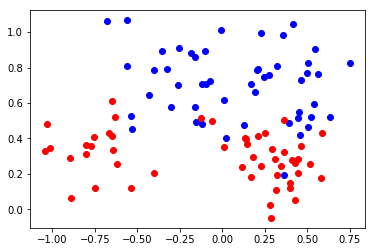

In [99]:
X, Y = genRipley()
classA = X[Y == 1]
classB = X[Y == -1]

plt.plot(classA[:,0], classA[:,1], 'bo')
plt.plot(classB[:,0], classB[:,1], 'ro')

plt.show()

## U.S.P.S Dataset

In [100]:
def genUSPS():
    # Load file content
    training_file = dirData + '/usps.train'
    test_file = dirData + '/usps.test'
    train_data = np.loadtxt(training_file)
    test_data = np.loadtxt(test_file)
    # Seperate to input and output
    X_tr = train_data[:, 1:train_data.shape[1]]
    Y_tr = train_data[:,0] 
    X_ts = test_data[:, 1:test_data.shape[1]]
    Y_ts = test_data[:,0] 
    return X_tr, Y_tr, X_ts, Y_ts

# Regression algorithms

In [103]:
class ParameterValueError(Exception):
    """ Custom exception raised when a parameter has an invalid value."""
    pass

class FailedOptimizationError(Exception):
    """ Custom exception raised when a the optimization process fails."""
    pass

class UntrainedModelError(Exception):
    """ Custom exception raised when an untrained model is called to make predictions."""
    pass

## RVM

In [12]:
# RVM class
class RVM_reg:
    """ Relevance Vector Machine (RVM)
    
    Implementation of RVM for both regression and classification.
    
    Attributes:
        kerType: A string of the type of the desired kernel.
        rvmType: A string denoting the RVM type to be used. The string "EM" denotes
            an EM-like algorithm will be used to estimate the hyperparameters, the
            string "DD" denotes the direct differentiation approach while "SSBL"
            denotes sequential sparse bayesian learning.
        p: Integer value denoting the degree of the polynomial kernel.
        sigma: Float value denoting the smoothing factor of the Gaussian kernel.
        kappa: Float value denoting the scaling parameter of the sigmoid kernel.
        delta: Float value denoting the translation parameter of the sigmoid kernel.
        bTrained: boolean value which becomes true once the RVM has been trained.
    """

    EPSILON_CONV = 1e-6
    EPSILON_UF = 1e-30
    TH_RV = 1e5
    INFINITY = 1e20
    maxEpochs = 5000
    
    def __init__(self, kerType = 'poly', rvmType = "EM", p = 1, sigma = 1, 
                 kappa = 1, delta = 1):
        """ Initializes the RVM class (constructor).
        
            Raises:
                ParameterValueError: An error occured because a parameter had an
                    invalid value.  
        """
        # Check if the kernel type chosen is valid
        kerTypes = ['linear', 'poly', 'radial', 'sigmoid']
        if kerType not in kerTypes:
            raise ParameterValueError("ParameterValueError: The string " + kerType + \
                                       " does not denote a valid kernel type")
        # Check if the string denoting the rvmType has a valid value
        if rvmType != 'EM' and rvmType != 'DD' and rvmType != "SSBL":
            raise ParameterValueError('ParameterValueError: ' + rvmType, \
                                       " is not a valid RVM type value. Enter 'EM', 'DD' or 'SSBL' as a value. ")
       
        self.kerType = kerType
        self.rvmType = rvmType
        self.p = p
        self.sigma = sigma
        self.kappa = kappa
        self.delta = delta
        self.bTrained = False

    def kernel(self, x, y):
        """ Kernel computation.
        
        It computes the kernel value based on the dot product
        between two vectors.
        
        Args:
            x: Input vector.
            y: Other input vector.
            
        Returns:
            The computed kernel value.
        """  
        if self.kerType == "linear":
            k = np.dot(x,y) + 1
        elif self.kerType == "poly":
            k = (np.dot(x,y) + 1) ** self.p
        elif self.kerType == "radial":
            k = math.exp(-(np.dot(x-y,x-y))/(2*self.sigma))
        elif self.kerType == "sigmoid":
            k = math.atanh(self.kappa * np.dot(x,y) - self.delta)

        return k
    
    def getKernelMatrix(self, X, training = True):
        """ Evaluates the kernel matrix K given a set of input samples (training).

        Args:
            X_tr: A NxM matrix with a M dimensional training input sample
                in each row.

        Returns:
            An NxN Kernel matrix where N is the number of input samples.
        """
        N = X.shape[0]
        if training == True:
            K = np.zeros((N, N))
            for i in range(N):
                for j in range(N):
                    K[i,j] = self.kernel(X[i], X[j])
        else:
            N_sv = self.X_sv.shape[0]
            K = np.zeros((N,N_sv))
            for i in range(N):
                for j in range(N_sv):
                    K[i,j] = self.kernel(X[i], self.X_sv[j])
        return K

    def getGammaValues(self, alpha_values, Sigma):
        """Evaluates the gamma values.
        
        Args:
            alpha_values: N-dimensional vector with the hyperparameters of
                the marginal likelihood.
            Sigma: NxN covariance matrix of the posterior

        Returns: A N-dimensional vector with the gamma values where 
            gamma_values[i] = 1 - alpha_values[i] * Sigma[i][i]
        """
        N = alpha_values.shape[0]
        gamma_values = 1 - np.multiply(alpha_values, np.diag(Sigma))
        return gamma_values
        
    def getAlphaValues(self, Sigma, mu, gamma_values):
        """Evaluates the alpha values.

        Args:
            Sigma: NxN covariance matrix of the posterior
            mu: mean of the posterior
            gamma_values: N-dimensional vector with gamma_values

        Returns: A N-dimensional vector with the alpha_values
        """        
        N = Sigma.shape[0]
        alpha_values = np.zeros(N)
        if self.rvmType == "EM":
            cond_low = (np.diag(Sigma) + mu**2) < self.EPSILON_UF
            cond_high = (np.diag(Sigma) + mu**2) > self.INFINITY
            ncond = np.logical_and(np.logical_not(cond_low), np.logical_not(cond_high))
            alpha_values[cond_low] = self.INFINITY
            alpha_values[cond_high] = 0
            alpha_values[ncond] = 1 / (np.diag(Sigma)[ncond] + mu[ncond]**2)
        elif self.rvmType == "DD":
            cond_low = (mu**2) < self.EPSILON_UF
            cond_high = (mu**2) > self.INFINITY
            ncond = np.logical_and(np.logical_not(cond_low), np.logical_not(cond_high))
            alpha_values[cond_low] = self.INFINITY
            alpha_values[cond_high] = 0
            alpha_values[ncond] = gamma_values[ncond] / (mu[ncond]**2)
        return alpha_values

    
    def train(self, X_tr, Y_tr):
        """ RVM training method
        
        Applies an EM-like algorithm or direct differentiation to estimate the
        optimal hyperparameters (alpha and sigma) needed to make predictions
        using the marginal likelihood.
        Alternatively, applies the Sequential Sparse Bayesian Algorithm to estimate
        the optimal hyperparemeters (alpha and sigma) more efficiently.
        
        
        Args:
            X_tr: A matrix with a training input sample in each row.
            Y_tr: A vector with the output values of each input sample
                in X_tr.
        
        Returns:
            None
        """
        # Get number of training data samples
        N = X_tr.shape[0]
        # Initialize the sigma squared value and the B matrix
        sigma_squared = np.var(Y_tr) * 0.1
        B = np.identity(N) / sigma_squared
        # Calculate kernel matrix K and append a column with ones in the front 
        K = self.getKernelMatrix(X_tr)        
        K = np.hstack((np.ones(N).reshape((N, 1)), K))
        

        if(self.rvmType == "EM" or self.rvmType =="DD"):
            ''' 
            Implementation based on the following paper Tipping, Michael. 
            "Relevance vector machine." U.S. Patent No. 6,633,857. 14 Oct. 2003.
            '''
            # Initialize the alpha values (weight precision values) and the A matrix
            alpha_values = np.ones(N + 1)
            A = np.diag(alpha_values)
            # Calculate Sigma and mu based on the initialized parameters
            try:
                Sigma = np.linalg.inv(K.T.dot(B).dot(K) + A)
            except linalg.LinAlgError:
                Sigma = np.linalg.pinv(K.T.dot(B).dot(K) + A)
            mu = Sigma.dot(K.T).dot(B).dot(Y_tr)
            # Calculate initial gamma values
            gamma_values = self.getGammaValues(alpha_values, Sigma)

            # Approximate optimal hyperparameter values iteratively
            for epoch in range(self.maxEpochs):
                # Evaluate alpha values
                next_alpha_values = self.getAlphaValues(Sigma, mu, gamma_values)
                # Evaluate sigma value
                next_sigma_squared = (np.linalg.norm(Y_tr - K.dot(mu)) ** 2) / (N - np.sum(gamma_values))
                # Check if algorithm has converged (variation of alpha and sigma)
                if (np.sum(np.absolute(next_alpha_values - alpha_values)) < self.EPSILON_CONV and
                    abs(next_sigma_squared - sigma_squared) < self.EPSILON_CONV):
                        break
                # If algorithm has not converged, update all the variables
                alpha_values = next_alpha_values
                sigma_squared = next_sigma_squared
                A = np.diag(alpha_values)
                B = np.identity(N) / sigma_squared
                try:
                    Sigma = np.linalg.inv(K.T.dot(B).dot(K) + A)
                except linalg.LinAlgError:
                    Sigma = np.linalg.pinv(K.T.dot(B).dot(K) + A) 
                mu = Sigma.dot(K.T).dot(B).dot(Y_tr)
                gamma_values = self.getGammaValues(alpha_values, Sigma)
                
            # We store the support vectors and other important variables
            cond_sv = alpha_values < self.TH_RV
            self.X_sv = X_tr[cond_sv[1:N+1]]
            self.Y_sv = Y_tr[cond_sv[1:N+1]]
            self.mu = mu[cond_sv]
            self.Sigma = Sigma[cond_sv][:,cond_sv]
            self.sigma_squared = sigma_squared
            
        elif self.rvmType == "SSBL":     
            """
            Implementation based on the following paper: Tipping, M.E. and Faul, A.C., 2003, January.
            Fast marginal likelihood maximisation for sparse Bayesian models. In AISTATS.
            """
            
            # 2. Initialize one alpha value and set all the others to infinity.
            alpha_values = np.zeros(N + 1) + self.INFINITY
            basis_column = K[:,0]
            phi_norm = np.linalg.norm(basis_column)
            alpha_values[0] = phi_norm / ((np.linalg.norm(basis_column.dot(Y_tr)) ** 2) \
                                          / (phi_norm ** 2) - sigma_squared)
            included_cond = np.zeros(N + 1, dtype=bool)
            included_cond[0] = True
            
            # 3. Initialize Sigma and mu
            A = np.zeros(1) + alpha_values[0]
            basis_column = basis_column.reshape((N, 1)) # Reshape so that it can be transposed
            Sigma = 1 / (basis_column.T.dot(B).dot(basis_column) + A)
            mu = Sigma.dot(basis_column.T).dot(B).dot(Y_tr)

            # 3. Initialize q and s for all bases
            q = np.zeros(N + 1)
            Q = np.zeros(N + 1)
            s = np.zeros(N + 1)
            S = np.zeros(N + 1)
            Phi = basis_column
            for i in range(N + 1):
                basis = K[:, i]
                tmp_1 = basis.T.dot(B)
                tmp_2 = tmp_1.dot(Phi).dot(Sigma).dot(Phi.T).dot(B)
                Q[i] = tmp_1.dot(Y_tr) - tmp_2.dot(Y_tr)
                S[i] = tmp_1.dot(basis) - tmp_2.dot(basis)
            denom = (alpha_values - S)
            s = (alpha_values * S) / denom
            q = (alpha_values * Q) / denom
            
            # Create queue with indices to select candidates for update
            queue = deque([i for i in range(N + 1)])
            # Start updating the model iteratively
            for epoch in range(self.maxEpochs):
                # 4. Pick a candidate basis vector from the start of the queue and put it at the end
                basis_idx = queue.popleft()
                queue.append(basis_idx)
                
                # 5. Compute theta
                theta = q ** 2 - s
                
                next_alpha_values = np.copy(alpha_values)
                next_included_cond = np.copy(included_cond)
                if theta[basis_idx] > 0 and alpha_values[basis_idx] < self.INFINITY:
                    # 6. Re-estimate alpha
                    next_alpha_values[basis_idx] = s[basis_idx] ** 2 / (q[basis_idx] ** 2 - s[basis_idx])
                    pass
                elif theta[basis_idx] > 0 and alpha_values[basis_idx] >= self.INFINITY:
                    # 7. Add basis function to the model with updated alpha
                    next_alpha_values[basis_idx] = s[basis_idx] ** 2 / (q[basis_idx] ** 2 - s[basis_idx])
                    next_included_cond[basis_idx] = True
                elif theta[basis_idx] <= 0 and alpha_values[basis_idx] < self.INFINITY:
                    # 8. Delete theta basis function from model and set alpha to infinity
                    next_alpha_values[basis_idx] = self.INFINITY
                    next_included_cond[basis_idx] = False
                    
                # 9. Estimate noise level
                gamma_values = 1 - np.multiply(alpha_values[included_cond], np.diag(Sigma))
                next_sigma_squared = (np.linalg.norm(Y_tr - Phi.dot(mu)) ** 2) / (N - np.sum(gamma_values))
                
                # 11. Check for convergence
                # Check if algorithm has converged (variation of alpha and sigma)
                not_included_cond = np.logical_not(included_cond)
                if (np.sum(np.absolute(next_alpha_values[included_cond] - alpha_values[included_cond])) \
                            < self.EPSILON_CONV) and all(th <= 0 for th in theta[not_included_cond]):              
                        break
                
                # 10. Recompute/update  Sigma and mu as well as s and q
                alpha_values = next_alpha_values
                sigma_squared = next_sigma_squared
                included_cond = next_included_cond
                A = np.diag(alpha_values[included_cond])
                B = np.identity(N) / sigma_squared
                Phi = K[:, included_cond]
                # Compute Sigma
                tmp = Phi.T.dot(B).dot(Phi) + A
                if(tmp.shape[0] == 1):
                    Sigma = 1 / tmp
                else:
                    try:
                        Sigma = np.linalg.inv(tmp)
                    except linalg.LinAlgError:
                        Sigma = np.linalg.pinv(tmp)
                    
                # Compute mu
                mu = Sigma.dot(Phi.T).dot(B).dot(Y_tr)
                # Update s and q
                for i in range(N + 1):
                    basis = K[:, i]
                    tmp_1 = basis.T.dot(B)
                    tmp_2 = tmp_1.dot(Phi).dot(Sigma).dot(Phi.T).dot(B)
                    Q[i] = tmp_1.dot(Y_tr) - tmp_2.dot(Y_tr)
                    S[i] = tmp_1.dot(basis) - tmp_2.dot(basis)
                denom = (alpha_values - S)
                s = (alpha_values * S) / denom
                q = (alpha_values * Q) / denom
            ##print(epoch)
            # We store the relevance vectors and other important variables
            self.X_sv = X_tr[included_cond[1:N+1]]
            self.Y_sv = Y_tr[included_cond[1:N+1]]
            self.mu = mu
            self.Sigma = Sigma
            self.sigma_squared = sigma_squared
            
            
        self.bTrained = True
    
    def pred(self, X):
        """Predicts the classes for a number of input data
        
        Args:
            X: matrix with input data where each row represents a sample.
            
        Returns:
            y: vector with the predicted class for each input sample.
            
        Raises:
            UntrainedModelError: Error that occurs when this function is called
                before calling the 'train' function.
        """
        
        if self.bTrained == False:
            raise UntrainedModelError("UntrainedModelError: The SVM model has not been trained.")
        
        N = X.shape[0]
        K = self.getKernelMatrix(X, training = False)  
        N_sv = np.shape(self.X_sv)[0]
        if np.shape(self.mu)[0] != N_sv:
            K = np.hstack((np.ones(N).reshape((N, 1)), K))
        y = K.dot(self.mu)
        err_var = self.sigma_squared + K.dot(self.Sigma).dot(K.T)
        return y, np.sqrt(np.diag(err_var))

    def getSV(self):
        return self.X_sv, self.Y_sv
               

## SVM

In [49]:
# SVM class
class SVM_reg:
    """ Support Vector Machine (SVM) for regression.
    
    Implementation of SVM for regression with an option to use
    both the original SVM formulation and the alternative v-SVM
    formulation.
    
    Attributes:
        kerType: A string of the type of the desired kernel.
        svmType: A string denoting the SVM type to be used. The string "C" denotes
            the original SVM formulation while the string "V" is used for the 
            alternative v-SVM formulation.
        V: V-variable.
        C: C-variable.
        p: Integer value denoting the degree of the polynomial kernel.
        sigma: Float value denoting the smoothing factor of the Gaussian kernel.
        kappa: Float value denoting the scaling parameter of the sigmoid kernel.
        delta: Float value denoting the translation parameter of the sigmoid kernel.
        eps: Float value denoting the size of the insensitive tube.
        bTrained: boolean value which becomes true once the SVM has been trained.
        a: the 'a' lagrangian multipliers of the SVM.
        a_hat: the 'a-hat' lagrangian multipliers of the SVM.
        b: the bias term of the SVM
        X_sv: the input values of the support vectors.
        Y_sv: the output values of the support vectors.
    """

    EPSILON = 1e-10
   
    def __init__(self, kerType = 'poly', svmType = 'C',
                 V = 0.45, C = 1, p = 1, sigma = 1, 
                 kappa = 1, delta = 1, eps = 0.5):
        """ Initializes the SVM class (constructor).
        
            Raises:
                ParameterValueError: An error occured because a parameter had an
                    invalid value.  
        """
        # Check if the kernel type chosen is valid
        kerTypes = ['linear', 'poly', 'radial', 'sigmoid']
        if kerType not in kerTypes:
            raise ParameterValueError("ParameterValueError: The string " + kerType + \
                                       " does not denote a valid kernel type")
        # Check if the string denoting the svmType has a valid value
        if svmType != 'C' and svmType != 'V':
            raise ParameterValueError('ParameterValueError: ' + svmType, \
                                       " is not a valid SVM type value. Enter 'C' or 'V' as a value. ")
        self.kerType = kerType
        self.svmType = svmType
        self.V = V
        self.C = C
        self.p = p
        self.sigma = sigma
        self.kappa = kappa
        self.delta = delta
        self.eps = eps
        self.bTrained = False

    def kernel(self, x, y):
        """ Kernel computation.
        
        It computes the kernel value based on the dot product
        between two vectors.
        
        Args:
            x: Input vector.
            y: Other input vector.
            
        Returns:
            The computed kernel value.
        """  
        if self.kerType == "linear":
            k = np.dot(x,y) + 1
        elif self.kerType == "poly":
            k = (np.dot(x,y) + 1) ** self.p
        elif self.kerType == "radial":
            k = math.exp(-(np.dot(x-y,x-y))/(2*self.sigma))
        elif self.kerType == "sigmoid":
            k = math.atanh(self.kappa * np.dot(x,y) - self.delta)

        return k
    
    def getKernelMatrix(self, X):
        """ Evaluates the kernel matrix K given a set of input samples.

            Args:
                X_tr: A NxM matrix with a M dimensional training input sample
                    in each row.
                
            Returns:
                An NxN Kernel matrix where N is the number of input samples.
        """
        N = X.shape[0]
        K = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                K[i,j] = self.kernel(X[i], X[j])
        return K
    
    def lagrange(self, params, y, K):
        """ The lagrangian objective function to be minimized.
        
        Args:
            params: A vector with all the a and a-hat Lagrange multipliers.          
            y: Vector with the true output values.
            K: Matrix with the kernel values computed between each input.
        
        Returns:
            The value of the lagrangian for the given parameters.
        """
        N2 = np.shape(params)[0]
        N = int(N2/2)
        a = params[0:N].reshape((N,1))
        a_hat = params[N:N2].reshape((N,1))
        y = y.reshape((N,1))
        if self.svmType == "C":
            L = (1/2) * (a - a_hat).T.dot(K).dot(a - a_hat) \
                + self.eps * np.sum(a + a_hat) \
                - (a - a_hat).T.dot(y)
        elif self.svmType == "V":
            L = (1/2) * (a - a_hat).T.dot(K).dot(a - a_hat) \
                    - (a - a_hat).T.dot(y)
        return L
    
    def train(self, X_tr, Y_tr):
        """ SVM training method
        
        Trains the SVM by minimizing the lagrangian function given the
        training input and output samples.
        
        Args:
            X_tr: A matrix with a training input sample in each row.
            Y_tr: A vector with the output values of each input sample
                in X_tr.
        
        Returns:
            None
        
        Raises:
            FailedOptimizationError: An error occured because the optimization
                of the lagrangian failed.
        """
        N_tr = np.shape(X_tr)[0]
        K = self.getKernelMatrix(X_tr)
        args = (Y_tr, K)
        
        bounds = []
        if self.svmType == "C":
            for i in range(0, 2*N_tr):
                bounds.append((0,self.C))
        elif self.svmType == "V":
            for i in range(0, 2*N_tr):
                bounds.append((0,self.C / N_tr))
        
        def constraint_a(params):
            N2 = np.shape(params)[0]
            N = int(N2/2)
            a = params[0:N]
            a_hat = params[N:N2]
            return np.sum(a - a_hat)
        
        def constraint_b(params):
            N2 = np.shape(params)[0]
            N = int(N2/2)
            a = params[0:N]
            a_hat = params[N:N2]
            return self.V * self.C - np.sum(a + a_hat)

        if self.svmType == "C":
            cons = {'type':'eq', 'fun': constraint_a}
        elif self.svmType == "V":
            cons = [{'type':'eq', 'fun': constraint_a},
                {'type':'ineq', 'fun' : constraint_b}]

        
        initial = np.zeros(2*N_tr)
        final = optimize.minimize(self.lagrange, initial, args, \
            bounds=bounds, constraints=cons, method='SLSQP', tol = self.EPSILON)
        
        if final.success != True:
            raise FailedOptimizationError("FailedOptimizationError: The optimization was not successful.")
        
        a = final.x[0:N_tr]
        a_hat = final.x[N_tr:2*N_tr]
        
        b_sum = 0
        count = 0
        # Average over all estimates of b for samples with a or a_hat between 0 and C
        for i in range(N_tr):
            if a[i] > 0 and a[i] < self.C:
                count += 1
                b_sum += Y_tr[i] - self.eps - (a - a_hat).T.dot(K)[i]
            if a_hat[i] > 0 and a_hat[i] < self.C:
                count += 1
                b_sum += Y_tr[i] + self.eps - (a - a_hat).T.dot(K)[i]
        b = b_sum / count
  
    
        cond_valuable = np.logical_or(a > self.EPSILON, a_hat > self.EPSILON)
        a = a[cond_valuable]
        a_hat = a_hat[cond_valuable]
        X_sv = X_tr[cond_valuable]
        Y_sv = Y_tr[cond_valuable]
        
        self.a = a
        self.a_hat = a_hat
        self.b = b
        self.X_sv = X_sv
        self.Y_sv = Y_sv
        self.bTrained = True
        
    def pred(self, X):
        """Predicts the outputs for a number of input data
        
        Args:
            X: matrix with input data where each row represents a sample.
            
        Returns:
            y: vector with the predicted output for each input sample.
            
        Raises:
            UntrainedModelError: Error that occurs when this function is called
                before calling the 'train' function.
        """
        
        if self.bTrained == False:
            raise UntrainedModelError("UntrainedModelError: The SVM model has not been trained.")
        
        N_sv = np.shape(self.X_sv)[0]
        N = np.shape(X)[0]
        a = self.a.reshape(N_sv,1)
        a_hat = self.a_hat.reshape(N_sv,1)
        K = np.zeros((N_sv, N))
        for i in range(N_sv):
            for j in range(N):
                K[i,j] = self.kernel(self.X_sv[i],X[j])
        y = (a - a_hat).T.dot(K) + self.b
        y = y.reshape(-1)
        return y
    
    def getSV(self):
        return self.X_sv, self.Y_sv

## Plot function for 1D datasets

In [7]:
def printTest(X,Y,X_tst,Y_tst,X_sv,Y_sv,eps, typeR = 'RVM'):
    plt.plot(X,Y,'go')
    plt.plot(X_tst, Y_tst, 'b')
    plt.fill_between(X_tst, Y_tst-eps, Y_tst+eps, \
        facecolor='lightblue', interpolate=True, alpha=0.5)
    plt.plot(X_sv, Y_sv, 'ko', markersize = 15, mfc = "None")
    if typeR == 'RVM':
        plt.legend(['Training points', \
                    'Regression', \
                    'SV', \
                    'Prediction Standard Deviation'])
    else:
        plt.legend(['Training points', \
                    'Regression', \
                    'SV', \
                    'Insensitive tube'])
    plt.show()

# Regression Analysis

In [ ]:
X_tr, Y_tr, X_tst, Y_tst = genSinc1()

C_values = [1, 3, 5, 10, 20, 40]
epsilon_values = [0.05, 0.1, 0.2, 0.4]
params = tune_hyperparams(X_tr, Y_tr, C_values, epsilon_values, "svm_reg")
print(params)

    
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

division by zero
name 'FailedOptimizationError' is not defined
name 'FailedOptimizationError' is not defined
name 'FailedOptimizationError' is not defined
name 'FailedOptimizationError' is not defined


In [50]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Sinc with Gaussian error")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))
printTest(X_tr, Y_tr, X_tst, pred_rvm_EM, X_rv_EM, \
          Y_rv_EM, ser_EM, typeR='RVM')
printTest(X_tr, Y_tr, X_tst, pred_rvm_DD, X_rv_DD, \
          Y_rv_DD, ser_DD, typeR='RVM')
printTest(X_tr, Y_tr, X_tst, pred_BL, X_rv_BL, \
          Y_rv_BL, ser_BL, typeR='RVM')

KeyboardInterrupt: 

In [179]:
X_tr, Y_tr, X_tst, Y_tst = genSinc2()
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

Sinc with uniform error
EM error: 0.0540040057945
DD error: 0.053978183458
BL error: 0.0536362568611
EM Relevant vectors: 16.0
DD Relevant vectors: 9.0
BL Relevant vectors: 14.0


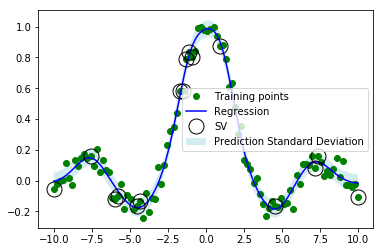

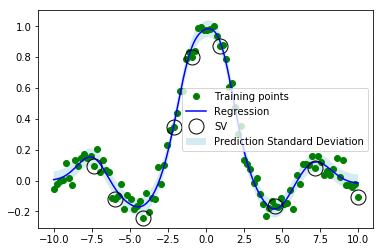

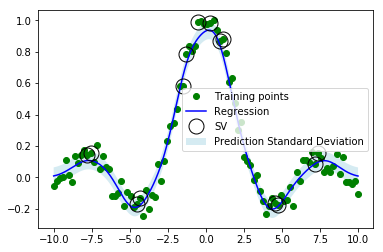

In [180]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Sinc with uniform error")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))
printTest(X_tr, Y_tr, X_tst, pred_rvm_EM, X_rv_EM, \
          Y_rv_EM, ser_EM, typeR='RVM')
printTest(X_tr, Y_tr, X_tst, pred_rvm_DD, X_rv_DD, \
          Y_rv_DD, ser_DD, typeR='RVM')
printTest(X_tr, Y_tr, X_tst, pred_BL, X_rv_BL, \
          Y_rv_BL, ser_BL, typeR='RVM')

In [170]:
X_tr, Y_tr, X_tst, Y_tst = genFriedman1()
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

In [171]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Friedman #1")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))

EM error: 0.0645746113457
DD error: 0.0645941865039
BL error: 0.064293188045
EM Relevant vectors: 209.0
DD Relevant vectors: 5.0
BL Relevant vectors: 181.0


In [185]:
X_tr, Y_tr, X_tst, Y_tst = genFriedman2()
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

In [186]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Friedman #2")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))

Friedman #2
EM error: 0.166252048443
DD error: 0.16659470407
BL error: 0.16490751215
EM Relevant vectors: 237.0
DD Relevant vectors: 233.0
BL Relevant vectors: 236.0


In [189]:
X_tr, Y_tr, X_tst, Y_tst = genFriedman3()
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

In [190]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Friedman #3")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))

Friedman #3
EM error: 0.0529320692401
DD error: 0.0535523696463
BL error: 0.0520360429361
EM Relevant vectors: 219.0
DD Relevant vectors: 217.0
BL Relevant vectors: 238.0


In [207]:
X_tr, Y_tr, X_tst, Y_tst = genBoston()
print(Y_tst.shape)
rvmEM = RVM_reg(rvmType='EM', kerType='radial', sigma = 1)
rvmDD = RVM_reg(rvmType='DD', kerType='radial', sigma = 1)
rvmBL = RVM_reg(rvmType='SSBL', kerType='radial', sigma = 1)

(206,)


In [208]:
e_rvm_EM = 0
e_rvm_DD = 0
e_rvm_BL = 0
N_rv_EM = 0
N_rv_DD = 0
N_rv_BL = 0
N_tst = Y_tst.shape[0]
S = 1
for i in range(S):    
    rvmEM.train(X_tr, Y_tr)
    rvmDD.train(X_tr, Y_tr)
    rvmBL.train(X_tr, Y_tr)
    pred_rvm_EM, ser_EM = rvmEM.pred(X_tst)
    pred_rvm_DD, ser_DD = rvmDD.pred(X_tst)
    pred_rvm_BL, ser_BL = rvmBL.pred(X_tst)
    e_rvm_EM += np.sum(np.abs(pred_rvm_EM - Y_tst)) / N_tst
    e_rvm_DD += np.sum(np.abs(pred_rvm_DD - Y_tst)) / N_tst
    e_rvm_BL += np.sum(np.abs(pred_rvm_BL - Y_tst)) / N_tst
    X_rv_EM, Y_rv_EM = rvmEM.getSV()
    X_rv_DD, Y_rv_DD = rvmDD.getSV()
    X_rv_BL, Y_rv_BL = rvmBL.getSV()
    N_rv_EM += np.shape(X_rv_EM)[0]
    N_rv_DD += np.shape(X_rv_DD)[0]
    N_rv_BL += np.shape(X_rv_BL)[0]
maxErr = np.max([e_rvm_EM, e_rvm_DD, e_rvm_BL])
e_rvm_EM /= S
e_rvm_DD /= S
e_rvm_BL /= S
N_rv_EM /= S
N_rv_DD /= S
N_rv_BL /= S
print("Friedman #3")
print("EM error: " + str(e_rvm_EM))
print("DD error: " + str(e_rvm_DD))
print("BL error: " + str(e_rvm_BL))
print("EM Relevant vectors: " + str(N_rv_EM))
print("DD Relevant vectors: " + str(N_rv_DD))
print("BL Relevant vectors: " + str(N_rv_BL))

Friedman #3
EM error: 0.142738442241
DD error: 0.157728155326
BL error: 0.158505360632
EM Relevant vectors: 9.0
DD Relevant vectors: 9.0
BL Relevant vectors: 8.0
